# Определение перспективного тарифа для телеком компании

Проведем предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.

### 1. Импортируем нужные нам библиотеки и прочитаем предоставленные данные. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tarif = pd.read_csv('/datasets/tariffs.csv')


In [22]:
df_list = {'calls': calls, 'internet':internet, 'messages':messages, 'users':users, 'tarif':tarif}
for df in df_list:
    print('Данные таблицы {}'.format(df))
    display(df_list[df].head())
    display(df_list[df].info())
    display(df_list[df].duplicated().sum())

Данные таблицы calls


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null int64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: int64(3), object(2)
memory usage: 7.7+ MB


None

0

Данные таблицы internet


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,113,2018-11-25,1000,11
1,1,1000_1,1053,2018-09-07,1000,9
2,2,1000_2,1198,2018-06-25,1000,6
3,3,1000_3,551,2018-08-22,1000,8
4,4,1000_4,303,2018-09-24,1000,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null int64
session_date    149396 non-null object
user_id         149396 non-null int64
month           149396 non-null int64
dtypes: int64(4), object(2)
memory usage: 6.8+ MB


None

0

Данные таблицы messages


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
month           123036 non-null int64
dtypes: int64(2), object(2)
memory usage: 3.8+ MB


None

0

Данные таблицы users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

0

Данные таблицы tarif


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

0

Прочитав данные видно, что дупликатов нет ни в одной из предоставленных таблиц.

Для таблицы calls, нужно окгруглить значения столбца duration в большую сторону и сменить тип данных на int.

Для таблицы internet, нужно окгруглить значения столбца mb_used в большую сторону и сменить тип данных на int. Есть лишний столбец Unnamed:0, его мы трогать не будем, он нам не понадобится в дальнейшем.

Для таблицы users, много пропусков в столбце churn_date, с ним работать не будем, поэтому оставим все как есть.



### Шаг 2. Подготовка данных

Сделаем преобразования для таблицы calls и internet в столбцах 'duration' и 'mb_used' соответсвенно. 

In [4]:
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)

Добавим в предоставленные таблицы новый столбец, месяц совершения операции. После этого сгруппируем каждую табличку по id абонента и месяцу. Объединим полученные данные в одну таблицу, после этого, присоединим эту таблицу с таблицей с данными о пользователях и их тарифах.

In [5]:
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
internet['month'] = pd.to_datetime(internet['session_date']).dt.month


In [6]:
calls_grouped = calls.groupby(['user_id', 'month']).agg({'duration':'sum'}).reset_index().rename(columns={'duration':'minutes_used'})
messages_grouped = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index().rename(columns={'id':'message_used'})
internet_grouped = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()


In [7]:
data = users.merge(tarif, left_on='tariff', right_on='tariff_name', how='left')
group = messages_grouped.merge(calls_grouped, on=['user_id','month'], how='outer')
group = group.merge(internet_grouped, on=['user_id', 'month'], how='outer')
data = data.merge(group, on='user_id', how='left')

In [8]:
data.info()
data.isna().mean()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
user_id                  3216 non-null int64
age                      3216 non-null int64
churn_date               189 non-null object
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null object
tariff                   3216 non-null object
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
tariff_name              3216 non-null object
month                    3214 non-null float64
message_used             2717 non-null float64
minutes_used             3174 non-null float64
mb_used                  3

user_id                  0.000000
age                      0.000000
churn_date               0.941231
city                     0.000000
first_name               0.000000
last_name                0.000000
reg_date                 0.000000
tariff                   0.000000
messages_included        0.000000
mb_per_month_included    0.000000
minutes_included         0.000000
rub_monthly_fee          0.000000
rub_per_gb               0.000000
rub_per_message          0.000000
rub_per_minute           0.000000
tariff_name              0.000000
month                    0.000622
message_used             0.155162
minutes_used             0.013060
mb_used                  0.004042
dtype: float64

В полученной таблице есть пропущенные значения в столбцах month, message_used, minutes_used, mb_used и нужно заменить некоторые типы данных.

---

В столбце month, есть два пропущенных значения. Взглянув на них видно, что данные абоненты зарегистрировались, но так и не воспользовались ни одной из услуг, и расторгли договор. Эти значения мы уберем из таблицы.

In [9]:
data.loc[data['month'].isna()]
data = data.dropna(subset=['month']).reset_index(drop=True)

---

В таблице остались пропущенные значения в столбцах с количеством использованных сообщений, минут и mb. Вероятнее всего, пропуски обозначают отсутсвие их использования.

In [10]:
data = data.fillna({'message_used': 0, 'minutes_used': 0, 'mb_used': 0})

---

При объединении у нас осталось в таблице два столбца с названием используемого тарифа, уберем один из них.

In [11]:
data.drop('tariff', axis=1, inplace=True)

---

Заменим типы данных в столбцах month, message_used, minutes_used, mb_used с float на int.

In [12]:
def type_changer (column):
    data[column] = data[column].astype(int)
type_changer('month')
type_changer('message_used')
type_changer('minutes_used')
type_changer('mb_used')

---

Для дальнейших рассчетов нам понадобится новые столбцы, с преобразованными данными использования интернета из mb в gb.

In [13]:
data['gb_used'] = (data['mb_used'] / 1024).apply(np.ceil).astype(int)
data['gb_included'] = (data['mb_per_month_included'] / 1024).astype(int)

Найдем помесячную выручки с каждого пользователя.

In [14]:
data['gb_over'] = (data['gb_used'] - data['gb_included']) * data['rub_per_gb']
data.loc[data['gb_over'] < 0, 'gb_over'] = 0
data['message_over'] = (data['message_used'] - data['messages_included']) * data['rub_per_message']
data.loc[data['message_over'] < 0, 'message_over'] = 0
data['minutes_over'] = (data['minutes_used'] - data['minutes_included']) * data['rub_per_minute']
data.loc[data['minutes_over'] < 0, 'minutes_over'] = 0
data['profit'] = data['gb_over'] + data['message_over'] + data['minutes_over'] + data['rub_monthly_fee']

---

### Шаг 3. Проанализируйте данные

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [15]:
data.groupby('tariff_name')[['gb_used', 'message_used', 'minutes_used', 'profit']].agg({'mean', 'median', 'var', 'std', 'sum'}).T.style.format('{:.2f}')

In [16]:
data['tariff_name'].value_counts()

smart    2229
ultra     985
Name: tariff_name, dtype: int64

Вывод: 
1. Среднее значение использования трафика для тарифа Смарт составляет 16 GB, что превышает объем трафика включенного в абонентскую плату. Среднее значения для тарифа Ультра выше и укладывается в лимит.
2. На тарифе Ультра пользователи чаще отправляют сообщения.
3. Пользователи тарифа Смарт в среднем разговаривают на полтора часа меньше, чем пользователи тарифа Ультра.
4. В среднем абоненты тарифа Смарт переплачивают сверх своей абонентской платы 700 рублей. Абоненты тарифа Ультра переплачивают на 120 рублей больше сверх своей абонентской платы.
5. Суммарный доход от пользователей тарифа Смарт составил 2 885 751 Рублей. Для тарифа Ультра 2 040 000 Рублей.
6. Количтесво пользователей тарифа Смарт 2229, а тарифа Ультра 985.



---
Построим гистограммы для двух тарифов

In [17]:
tariffs = ['smart', 'ultra']
palette = {'smart':'blue', 'ultra':'red'}
def hist_mean_quan (column):
    plt.figure(figsize=(13, 4))
    for tariff in tariffs:
        sns.distplot(data.query('tariff_name == @tariff')[column], kde=True, label=tariff, color=palette[tariff], bins=30)
        plt.axvline(data.query('tariff_name == @tariff')[column].mean(), color=palette[tariff])
        plt.axvline(data.query('tariff_name == @tariff')[column].quantile(0.95), linestyle=':', color=palette[tariff])
        plt.axvline(data.query('tariff_name == @tariff')[column].quantile(0.05), linestyle=':', color=palette[tariff])
        legend = plt.legend()


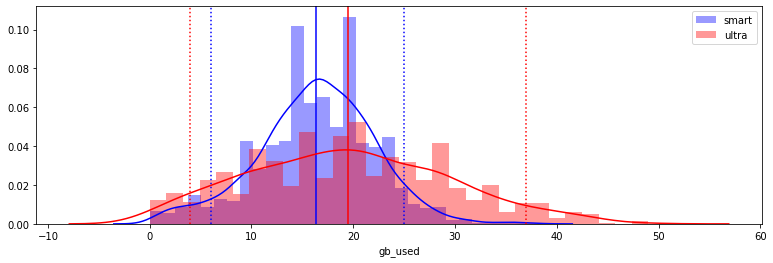

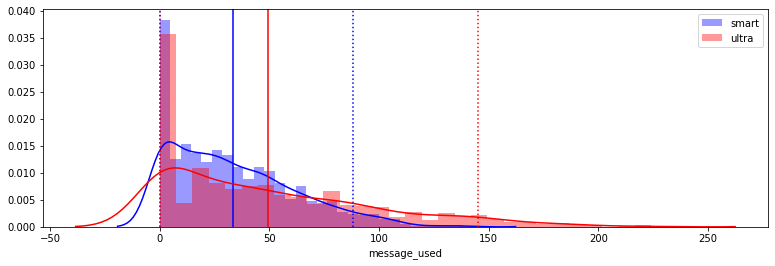

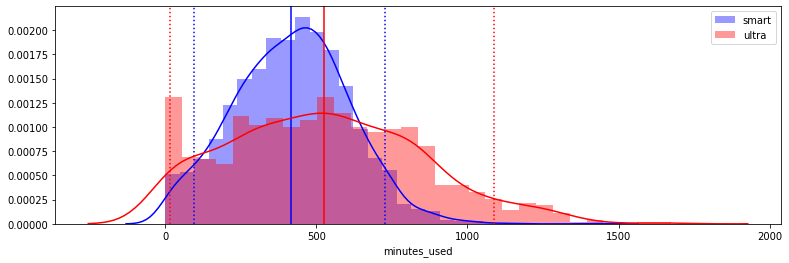

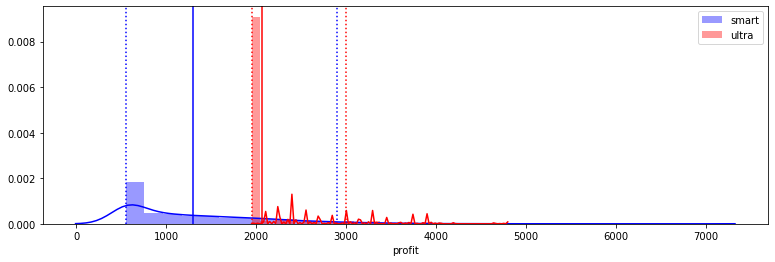

In [18]:
column_list = ['gb_used', 'message_used', 'minutes_used', 'profit']

for column in column_list:
    hist_mean_quan(column)

 - Количество использованного трафика и использованных минут имеют нормальное распределение. 
 - Количество отправленных сообщений экспоненциальное распределение.

---



### Шаг 4. Проверьте гипотезы




##### Проверим следующие гипотезы:
1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;


Для того что бы проверить первую гипотезу, примем за нулевую гипотезу то, что средние наших выборок равны. Альтернативной гипотезой в данном случае будет являться то, что средняя выручка пользователей разных тарифов различаются. Так как количество наблюдений >30, можем воспользоваться критерием t - Стьюдента.

In [19]:
alpha = .05
results = st.ttest_ind(data.query('tariff_name == "ultra"')['profit'], data.query('tariff_name == "smart"')['profit'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


Вывод: мы получили статистически значимые различия средних значений выручки пользователей разных тарифов, значение p-value слишком мало, поэтому нулевая гипотеза отвергается и можно утверждать что верна альтернативная гипотеза. То есть наша гипотеза о том, что _средняя выручка пользователей тарифов "Ультра" и "Смарт" различается_ - верна.

---
Для того что бы проверить вторую гипотезу, примем за нулевую гипотезу то, что средние наших выборок равны. Альтернативной гипотезой в данном случае будет являться то, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Так как количество наблюдений >30, можем воспользоваться критерием t - Стьюдента.

In [20]:
alpha = .05
results = st.ttest_ind(data.query('city == "Москва"')['profit'], data.query('city != "Москва"')['profit'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


Вывод: полученное значение p-value слишком большое, чтобы делать вывод о значимом различии между средней выручкой пользователей из Москвы и средней выручкой пользователей из других регионов.

---
Построим гистограмму, что наглядно в этом убедиться.

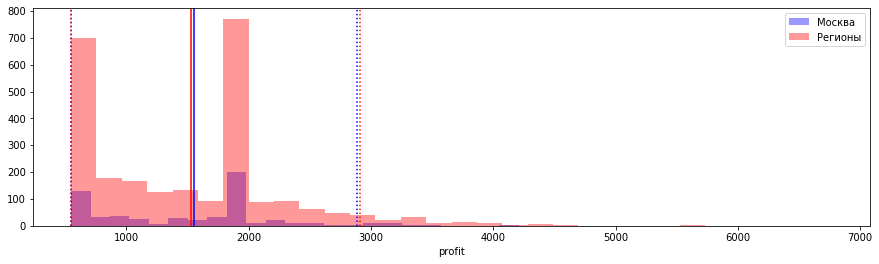

In [21]:
plt.figure(figsize=(15, 4))
sns.distplot(data.query('city == "Москва"')['profit'], kde=False, label='Москва', color='blue', bins=30)
sns.distplot(data.query('city != "Москва"')['profit'], kde=False, label='Регионы', color='red', bins=30)
plt.axvline(data.query('city == "Москва"')['profit'].mean(), color='blue')
plt.axvline(data.query('city == "Москва"')['profit'].quantile(0.95), linestyle=':', color='blue')
plt.axvline(data.query('city == "Москва"')['profit'].quantile(0.05), linestyle=':', color='blue')
plt.axvline(data.query('city != "Москва"')['profit'].mean(), color='red')
plt.axvline(data.query('city != "Москва"')['profit'].quantile(0.95), linestyle=':', color='red')
plt.axvline(data.query('city != "Москва"')['profit'].quantile(0.05), linestyle=':', color='red')
legend = plt.legend()

На гистограмме видно что наши выборочные средние практически идентичны.





---
### Шаг 5. Общий вывод

По результатам предварительного анализа двух тарифов и поведения пользователей, можно сделать следущие выводы:

В процессе анализа выяснилось, что в выборке больше клиентов с тарифом Смарт 2229, а клиентов с тарифом Ультра 985.
Суммарный доход от пользователей тарифа Смарт составил 2 885 751 Рублей. Для тарифа Ультра 2 040 000 Рублей.

Пользователи тарифа Смарт чаще докупают дополнительные ГБ, и минуты. Несмотря на это, тариф Ультра в среднем приносит больше прибыли.
Средняя выручка от клиента тарифа Ультра оказалась выше, чем у тарифа Смарт, 2071 рублей против 1294 рублей.

Подводя итоги, можно сказать что тариф Ультра для компании является более выгодным. 

